In [1]:
import numpy as np
import matplotlib.pyplot as plt
import operator
import torch

import timeit
import tracemalloc

from torch.autograd import Variable

### Helpers

In [2]:
def perf(f, n=20):
    print(f"Avg time: {timeit.timeit(f, number=n) / n * 1000} ms")
    sum_mem = (0, 0)
    for _ in range(n):
        tracemalloc.start()
        f()
        sum_mem = map(operator.add, sum_mem, tracemalloc.get_traced_memory())
        tracemalloc.stop()
    cur, peak = map(lambda m: f"{m / n / 1024} KB", sum_mem)
    print(f"Avg memory (cur, peak): {cur}, {peak}")
    return f()

### From 2nd lab

In [3]:
def gen_to_next(gen):
    def next_getter(*args):
        next(gen)
        return gen.send(args)

    return next_getter


def deviation(x, y):
    return lambda b: sum((y[i] - b[:, 0].dot(x[i])) ** 2 for i in range(len(y)))


def gradient_descent(lr, get_next_point, deviation, points_number, max_iter_num=300, eps=1e-4):
    result = np.array([[0], [0]])
    log = []
    diff = deviation(result)
    for i in range(max_iter_num):
        for batch_id in range(1, points_number, points_number):
            id = np.random.randint(batch_id, batch_id + points_number)
            result = get_next_point(result, id, lr)
        prev_diff, diff = diff, deviation(result)
        log.append([result[0, 0], result[1, 0]])
        if abs(diff - prev_diff) < eps:
            break
    # print(i + 1)
    return result, np.array(log)


def gradient_descent_next_point(x, y):
    def get_next_point(result, id, lr):
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        seq = xi.T.dot((xi.dot(result)) - yi)
        return result - lr * seq

    return get_next_point


def call_gradient_descent(batch_size: int):
    return gradient_descent(1e-2, gradient_descent_next_point(x, y), deviation(x, y), batch_size, len(y))


def momentum_next_point(x, y, beta):
    seq = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        seq = beta * seq + (1 - beta) * xi.T.dot((xi.dot(result)) - yi)
        yield result - lr * seq


def call_momentum(batch_size):
    return gradient_descent(1e-2, gen_to_next(momentum_next_point(x, y, 0.9)), deviation(x, y), batch_size, len(y))


def nesterov_next_point(x, y, beta):
    seq = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        seq = beta * seq + lr * xi.T.dot((xi.dot(result)) - yi)
        yield result - seq


def call_nesterov(batch_size):
    return gradient_descent(1e-2, gen_to_next(nesterov_next_point(x, y, 0.8)), deviation(x, y), batch_size, len(y))


def ada_grad_next_point(x, y):
    seq = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        grad = xi.T.dot((xi.dot(result)) - yi)
        seq += grad ** 2
        yield result - np.divide(lr, np.sqrt(seq)) * grad


def call_ada_grad(batch_size):
    return gradient_descent(1, gen_to_next(ada_grad_next_point(x, y)), deviation(x, y), batch_size, len(y))


def rms_prop_next_point(x, y, beta):
    seq = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        grad = xi.T.dot((xi.dot(result)) - yi)
        seq = beta * seq + (1 - beta) * grad ** 2
        yield result - np.divide(lr, np.sqrt(seq)) * grad


def call_rms_prop(batch_size):
    return gradient_descent(0.1, gen_to_next(rms_prop_next_point(x, y, 0.9)), deviation(x, y), batch_size, len(y))


def adam_next_point(x, y, beta, gamma):
    seq1 = 0
    seq2 = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        grad = xi.T.dot((xi.dot(result)) - yi)
        seq1 = beta * seq1 + (1 - beta) * grad
        seq2 = gamma * seq2 + (1 - gamma) * grad ** 2
        yield result - lr * np.divide(seq1, np.sqrt(seq2))


def call_adam(batch_size):
    return gradient_descent(0.1, gen_to_next(adam_next_point(x, y, 0.9, 0.9)), deviation(x, y), batch_size, len(y))


In [4]:
def optimize(optimizer, max_iter_num=300):
    output = None
    for epoch in range(max_iter_num):
        optimizer.zero_grad()
        output = model(xs)
        loss = loss_fn(output, ys)
        loss.backward()
        optimizer.step()
    return output


def draw_difference(our_result, pytorch_result):
    plt.subplot(1, 2, 1)
    plt.scatter(x_raw, y)
    plt.plot(x_raw, x.dot(perf(our_result)), c='yellow')
    plt.show()

    plt.subplot(1, 2, 2)
    plt.scatter(xs, ys)
    plt.plot(xs, perf(pytorch_result), c='yellow')
    plt.show()

DEFAULT
Avg time: 35.40617279977596 ms
Avg memory (cur, peak): 1.19033203125 KB, 13.76845703125 KB


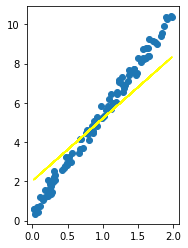

Avg time: 58.48397155023122 ms
Avg memory (cur, peak): 0.30927734375 KB, 2.410693359375 KB


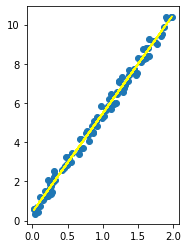

MOMENTUM
Avg time: 37.763227300092694 ms
Avg memory (cur, peak): 1.22158203125 KB, 14.27626953125 KB


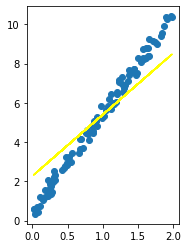

Avg time: 66.09427340008551 ms
Avg memory (cur, peak): 0.30927734375 KB, 2.551318359375 KB


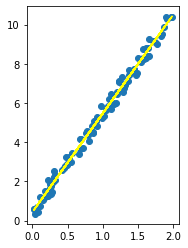

NESTEROV
Avg time: 35.59899874999246 ms
Avg memory (cur, peak): 1.201123046875 KB, 14.255810546875 KB


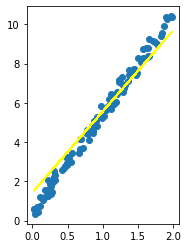

Avg time: 75.1257934000023 ms
Avg memory (cur, peak): 0.30927734375 KB, 2.61513671875 KB


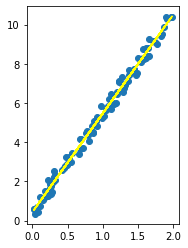

ADA GRAD
Avg time: 38.780727999983355 ms
Avg memory (cur, peak): 1.30087890625 KB, 14.46494140625 KB


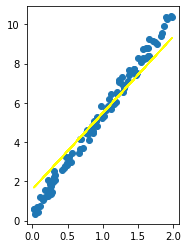

Avg time: 78.7218337001832 ms
Avg memory (cur, peak): 0.41318359375 KB, 2.644189453125 KB


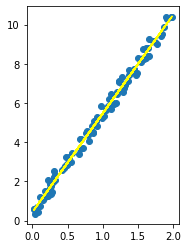

RMS PROP
Avg time: 40.990875649731606 ms
Avg memory (cur, peak): 1.30634765625 KB, 14.47041015625 KB


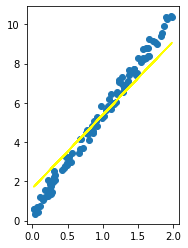

Avg time: 82.45355804974679 ms
Avg memory (cur, peak): 0.40498046875 KB, 2.815966796875 KB


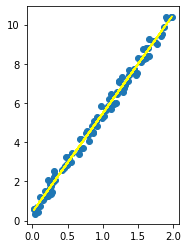

ADAM
Avg time: 40.56316614987736 ms
Avg memory (cur, peak): 1.33212890625 KB, 14.60556640625 KB


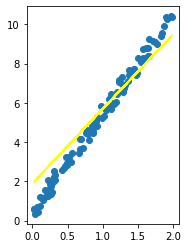

Avg time: 95.2404714498698 ms
Avg memory (cur, peak): 0.40224609375 KB, 2.971484375 KB


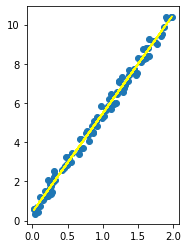

In [5]:
x_raw = 2 * np.random.rand(100, 1)
x = np.c_[np.ones((len(x_raw), 1)), x_raw]
y = 5 * x_raw + np.random.rand(100, 1)
xs = Variable(torch.tensor(np.array([x[:, 1]]).T).float())
ys = Variable(torch.tensor(y).float())
loss_fn = torch.nn.MSELoss()
model = torch.nn.Linear(1, 1)

print("DEFAULT")
draw_difference(
    lambda: call_gradient_descent(90)[0],
    lambda: optimize(torch.optim.SGD(model.parameters(), lr=1e-2)).detach().numpy()
)

print("MOMENTUM")
draw_difference(
    lambda: call_momentum(90)[0],
    lambda: optimize(torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)).detach().numpy()
)

print("NESTEROV")
draw_difference(
    lambda: call_nesterov(90)[0],
    lambda: optimize(torch.optim.SGD(model.parameters(), lr=1e-2, nesterov=True, momentum=0.9)).detach().numpy()
)

print("ADA GRAD")
draw_difference(
    lambda: call_ada_grad(90)[0],
    lambda: optimize(torch.optim.Adagrad(model.parameters(), lr=1)).detach().numpy()
)

print("RMS PROP")
draw_difference(
    lambda: call_rms_prop(90)[0],
    lambda: optimize(torch.optim.RMSprop(model.parameters(), lr=0.1)).detach().numpy()
)

print("ADAM")
draw_difference(
    lambda: call_adam(90)[0],
    lambda: optimize(torch.optim.Adam(model.parameters(), lr=0.1)).detach().numpy()
)